# Riiid Neural Oblivious Decision Ensembles

From paper [Neural Oblivious Decision Ensembles for Deep Learning on Tabular Data][1]. 

Github (Pytorch): https://github.com/Qwicen/node

Kaggle (Tensorflow): https://www.kaggle.com/marcusgawronsky/differentiable-catboost-node-in-tensorflow-2-0

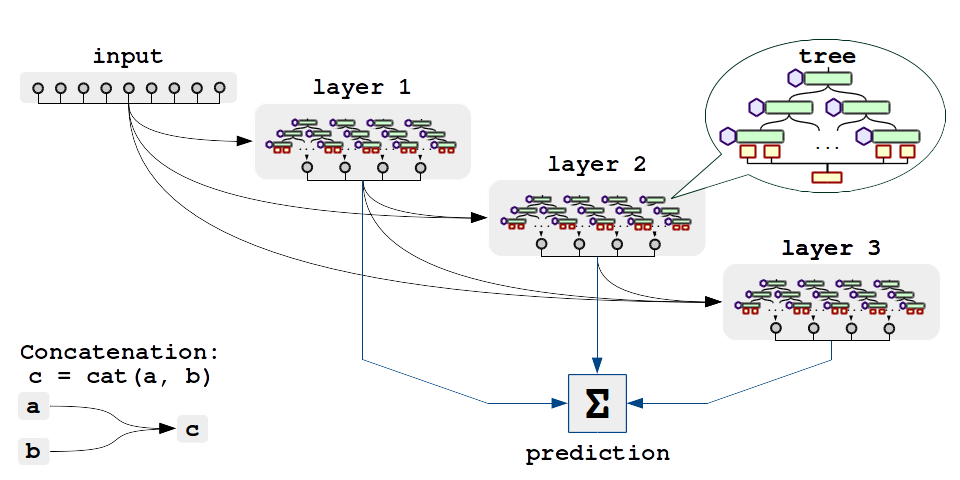

[1]: https://arxiv.org/pdf/1909.06312.pdf

In [ ]:
# useful
import random, os, math, sys, gc, datetime
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm
from typing import Union, Optional
from time import time
import warnings
warnings.filterwarnings('ignore')

# neural nets
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tensorflow_addons as tfa
import tensorflow_probability as tfp

# custom
import riiideducation

### CONSTANTS

In [ ]:
# PIVOT DATAFRAMES
piv1 = pd.read_csv("../input/riiid-fixed-infos/content.csv")
piv2 = pd.read_csv("../input/riiid-fixed-infos/task.csv")
piv3 = pd.read_csv("../input/riiid-fixed-infos/user.csv")

for col, df in zip(["content_sum", "task_container_sum", "user_sum"], [piv1, piv2, piv3]):
    df[col] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())
#
m1 = piv1["content_sum"].median()
m2 = piv2["task_container_sum"].median()
m3 = piv3["user_sum"].median()


# OTHER CONSTABTS
TARGET = "answered_correctly"
TIME_MEAN = 21000.0
TIME_MIN = 0.0
TIME_MAX = 300000.0
map_prior = {True:1, False:0}

In [ ]:
def preprocess(df):
    df = df.merge(piv1, how="left", on="content_id")
    df["content_emb"] = df["content_emb"].fillna(0.5)
    df["content_sum"] = df["content_sum"].fillna(m1)
    df = df.merge(piv2, how="left", on="task_container_id")
    df["task_container_emb"] = df["task_container_emb"].fillna(0.5)
    df["task_container_sum"] = df["task_container_sum"].fillna(m2)
    df = df.merge(piv3, how="left", on="user_id")
    df["user_emb"] = df["user_emb"].fillna(0.5)
    df["user_sum"] = df["user_sum"].fillna(m3)
    df["prior_question_elapsed_time"] = df["prior_question_elapsed_time"].fillna(TIME_MEAN)
    df["duration"] = (df["prior_question_elapsed_time"] - TIME_MIN) / (TIME_MAX - TIME_MIN)
    df["prior_answer"] = df["prior_question_had_explanation"].map(map_prior)
    df["prior_answer"] = df["prior_answer"].fillna(0.5)
    #df = df.fillna(-1)
    epsilon = 1e-6
    df["score"] = 2*df["content_emb"]*df["user_emb"] / (df["content_emb"]+ df["user_emb"] + epsilon)
    return df
#=========

## TRAINING

In [ ]:
%%time
tr = pd.read_csv("../input/riiid-test-answer-prediction/train.csv", 
                 low_memory=False, nrows=10**7)

In [ ]:
%%time
tr = preprocess(tr)

In [ ]:
FE = ["content_emb","content_sum" ,"task_container_emb", "task_container_sum",
      "user_emb", "user_sum","duration", "prior_answer","score"]

In [ ]:
x = tr.loc[tr.answered_correctly!=-1, FE].values
y = tr.loc[tr.answered_correctly!=-1, TARGET].values

# ODST

In [ ]:
@tf.function
def sparsemoid(inputs: tf.Tensor):
    return tf.clip_by_value(0.5 * inputs + 0.5, 0., 1.)

@tf.function
def identity(x: tf.Tensor):
    return x

class ODST(tf.keras.layers.Layer):
    def __init__(self, n_trees: int = 3, depth: int = 4, units: int = 1, threshold_init_beta: float = 1., **kwargs):
        super(ODST, self).__init__()
        self.initialized = False
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
    
    def build(self, input_shape: tf.TensorShape):
        feature_selection_logits_init = tf.zeros_initializer()
        self.feature_selection_logits = tf.Variable(initial_value=feature_selection_logits_init(shape=(input_shape[-1], self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)        
        
        feature_thresholds_init = tf.zeros_initializer()
        self.feature_thresholds = tf.Variable(initial_value=feature_thresholds_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        log_temperatures_init = tf.ones_initializer()
        self.log_temperatures = tf.Variable(initial_value=log_temperatures_init(shape=(self.n_trees, self.depth), dtype='float32'),
                                 trainable=True)
        
        indices = tf.keras.backend.arange(0, 2 ** self.depth, 1)
        offsets = 2 ** tf.keras.backend.arange(0, self.depth, 1)
        bin_codes = (tf.reshape(indices, (1, -1)) // tf.reshape(offsets, (-1, 1)) % 2)
        bin_codes_1hot = tf.stack([bin_codes, 1 - bin_codes], axis=-1)
        self.bin_codes_1hot = tf.Variable(initial_value=tf.cast(bin_codes_1hot, 'float32'), 
                                          trainable=False)
        
        response_init = tf.ones_initializer()
        self.response = tf.Variable(initial_value=response_init(shape=(self.n_trees, self.units, 2**self.depth), dtype='float32'), 
                                    trainable=True)
                
    def initialize(self, inputs):        
        feature_values = self.feature_values(inputs)
        
        # intialize feature_thresholds
        percentiles_q = (100 * tfp.distributions.Beta(self.threshold_init_beta, 
                                                      self.threshold_init_beta)
                         .sample([self.n_trees * self.depth]))
        flattened_feature_values = tf.map_fn(tf.keras.backend.flatten, feature_values)
        init_feature_thresholds = tf.linalg.diag_part(tfp.stats.percentile(flattened_feature_values, percentiles_q, axis=0))
        
        self.feature_thresholds.assign(tf.reshape(init_feature_thresholds, self.feature_thresholds.shape))
        
        
        # intialize log_temperatures
        self.log_temperatures.assign(tfp.stats.percentile(tf.math.abs(feature_values - self.feature_thresholds), 50, axis=0))
        
        
        
    def feature_values(self, inputs: tf.Tensor, training: bool = None):
        feature_selectors = tfa.activations.sparsemax(self.feature_selection_logits)
        # ^--[in_features, n_trees, depth]

        feature_values = tf.einsum('bi,ind->bnd', inputs, feature_selectors)
        # ^--[batch_size, n_trees, depth]
        
        return feature_values
        
    def call(self, inputs: tf.Tensor, training: bool = None):
        if not self.initialized:
            self.initialize(inputs)
            self.initialized = True
            
        feature_values = self.feature_values(inputs)
        
        threshold_logits = (feature_values - self.feature_thresholds) * tf.math.exp(-self.log_temperatures)

        threshold_logits = tf.stack([-threshold_logits, threshold_logits], axis=-1)
        # ^--[batch_size, n_trees, depth, 2]

        bins = sparsemoid(threshold_logits)
        # ^--[batch_size, n_trees, depth, 2], approximately binary

        bin_matches = tf.einsum('btds,dcs->btdc', bins, self.bin_codes_1hot)
        # ^--[batch_size, n_trees, depth, 2 ** depth]

        response_weights = tf.math.reduce_prod(bin_matches, axis=-2)
        # ^-- [batch_size, n_trees, 2 ** depth]

        response = tf.einsum('bnd,ncd->bnc', response_weights, self.response)
        # ^-- [batch_size, n_trees, units]
        
        return tf.reduce_sum(response, axis=1)
    
class NODE(tf.keras.Model):
    def __init__(self, units: int = 1, n_layers: int = 1, dropout_rate = 0.1, 
                 link: tf.function = tf.identity, n_trees: int = 3, depth: int = 4, 
                 threshold_init_beta: float = 1., feature_column: Optional[tf.keras.layers.DenseFeatures] = None, 
                 **kwargs):
        super(NODE, self).__init__()
        self.units = units
        self.n_layers = n_layers
        self.n_trees = n_trees
        self.depth = depth
        self.units = units
        self.threshold_init_beta = threshold_init_beta
        self.feature_column = feature_column
        self.dropout_rate = dropout_rate
        
        if feature_column is None:
            self.feature = tf.keras.layers.Lambda(identity)
        else:
            self.feature = feature_column
        
        self.bn = tf.keras.layers.BatchNormalization()
        self.dropout = tf.keras.layers.Dropout(self.dropout_rate)
        self.ensemble = [ODST(n_trees = n_trees,
                              depth = depth,
                              units = units,
                              threshold_init_beta = threshold_init_beta) 
                         for _ in range(n_layers)]
        
        self.link = link
        
    def call(self, inputs, training=None):
        X = self.feature(inputs)
        X = self.bn(X, training=training)
        X = self.dropout(X, training=training)
        
        for i, tree in enumerate(self.ensemble):
            H = tree(X)
            X = tf.concat([X, H], axis=1)
            
        return self.link(H)

# Model

In [ ]:
def create_NODE(n_layers, units, dropout_rate, depth, n_trees, link, learning_rate):
    
    node = NODE(n_layers = n_layers, units = units, dropout_rate = dropout_rate, 
                depth = depth, n_trees = n_trees, link = link)
    
    node.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate), 
                 metrics = [tf.keras.metrics.AUC(name = 'auc')], 
                 loss = 'binary_crossentropy')
    
    return node

# TRAIN

In [ ]:
N_STARTS = 1
N_SPLITS = 10
EPOCHS = 100
BATCH_SIZE = 30000
VERBOSE = 0

train = x
train_targets = y

res = np.zeros(train_targets.shape[0])

for seed in range(N_STARTS):
    start_time_seed = time()
    K.clear_session()
    tf.random.set_seed(seed)
    mean_score = 0
    skf = StratifiedKFold(n_splits = N_SPLITS, random_state = seed, shuffle = True)
    for n, (tr_idx, te_idx) in enumerate(skf.split(train_targets, train_targets)):
        
        start_time_fold = time()
        x_tr, x_val = train[tr_idx], train[te_idx]
        y_tr, y_val = train_targets[tr_idx], train_targets[te_idx]
            
        model = create_NODE(n_layers = 1, units = 1, dropout_rate = 0.3, depth = 6, 
                            n_trees = 16, link = tf.keras.activations.sigmoid, learning_rate = 1e-3)
        ckp = ModelCheckpoint(f'NODE_{seed}_{n}', monitor = 'val_auc', verbose = VERBOSE, 
                              save_best_only = True, save_weights_only = True, mode = 'max')
        rlr = ReduceLROnPlateau(monitor = 'val_auc', factor = 0.1, patience = 3, 
                                verbose = VERBOSE, min_delta = 1e-4, mode = 'max')
        es = EarlyStopping(monitor = 'val_auc', min_delta = 1e-4, patience = 5, mode = 'max', 
                           baseline = None, restore_best_weights = True, verbose = VERBOSE)
        history = model.fit(x_tr, y_tr, validation_data = (x_val, y_val), epochs = EPOCHS, 
                            batch_size = BATCH_SIZE, callbacks = [ckp, rlr, es], verbose = VERBOSE)
        hist = pd.DataFrame(history.history)
        fold_score = hist['val_auc'].max()
        mean_score += fold_score / N_SPLITS
        model.load_weights(f'NODE_{seed}_{n}')
        val_predict = model.predict(x_val, batch_size = BATCH_SIZE * 4)[:, 0]
        
        res[te_idx] += val_predict / N_STARTS
        print(f'[{str(datetime.timedelta(seconds = time() - start_time_fold))[2:7]}] NODE Seed {seed}, Fold {n}:', fold_score)
        break
    break
        
#     print(f'[{str(datetime.timedelta(seconds = time() - start_time_seed))[2:7]}] NODE Seed {seed} Mean Score:', mean_score)

In [ ]:
# print(f'NODE OOF Metric: {roc_auc_score(train_targets, res)}')

# PREDICTION

In [ ]:
env = riiideducation.make_env()
iter_test = env.iter_test()

In [ ]:
model = create_NODE(n_layers = 1, units = 1, dropout_rate = 0.3, depth = 6, 
                    n_trees = 16, link = tf.keras.activations.sigmoid, learning_rate = 1e-3)

# it = 0
for test_df, sample_prediction_df in iter_test:
#     it += 1
#     if it % 100 == 0:
#         print(it)
    test_df = preprocess(test_df)
    x_te = test_df[FE].values
    model.load_weights(f'NODE_0_0')
    test_df['answered_correctly'] = model.predict(x_te, batch_size = 50_000, verbose = 0)[:, 0]
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
#=================================================
# print(it)

In [ ]:
# it = 0
# for test_df, sample_prediction_df in iter_test:
#     it += 1
#     if it % 100 == 0:
#         print(it)
#     test_df = preprocess(test_df)
#     x_te = test_df[FE].values
#     test_df['answered_correctly'] = 0
#     for seed in range(N_STARTS):
#         for fold in range(N_SPLITS):
#             model = create_NODE(n_layers = 1, units = 1, dropout_rate = 0.3, depth = 6, 
#                                 n_trees = 16, link = tf.keras.activations.sigmoid, learning_rate = 1e-3)
#             model.load_weights(f'NODE_{seed}_{fold}')
#             test_df['answered_correctly'] += model.predict(x_te, batch_size = 50_000, verbose = 0)[:, 0] / (N_STARTS * N_SPLITS)
#     env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
# #=================================================
# print(it)